In [2]:
%matplotlib inline
import os
import torch
import torchvision
from torch import nn
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
d2l.use_svg_display()  # 使用svg来显示图片，提高清晰度  

# 权重衰减从零实现

## 高维线性回归
$y=0.05+\sum^{d}_{i-1}0.01x_i+\epsilon \quad where \quad \epsilon \sim \mathcal{N}(0,0.01^2)$

In [3]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5

true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05

train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

In [4]:
def init_params():
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

In [5]:
def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2

In [6]:
def train(lambd):
    w, b = init_params()
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    num_epochs, lr = 100, 0.003
    
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            # 增加了L2范数惩罚项，
            # ⼴播机制使l2_penalty(w)成为⼀个⻓度为batch_size的向量
            l = loss(net(X), y) + lambd * l2_penalty(w)
            l.sum().backward()
            d2l.sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                         d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数是： ', torch.norm(w).item())

## 忽略正则化训练

可以发现，训练误差有了减少，但是测试误差没有减少

w的L2范数是：  14.695111274719238


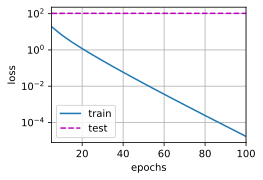

In [7]:
train(lambd=0)

## 使用权重衰减

训练误差增大，但是测试误差减小

w的L2范数是：  0.3624733090400696


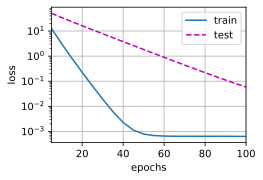

In [8]:
train(lambd=3)

# 权重衰减简洁实现

In [10]:
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    
    for param in net.parameters():
        param.data.normal_()
    
    loss = nn.MSELoss(reduction='none')
    num_epochs, lr = 100, 0.003
    
    # 偏置参数没有衰减
    trainer = torch.optim.SGD([{"params":net[0].weight,'weight_decay': wd},
                               {"params":net[0].bias}], lr=lr)
    
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    
    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1,(d2l.evaluate_loss(net, train_iter, loss),
                         d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数： ', net[0].weight.norm().item())

## 忽略正则化训练

可以发现，训练误差有了减少，但是测试误差没有减少

w的L2范数：  14.340202331542969


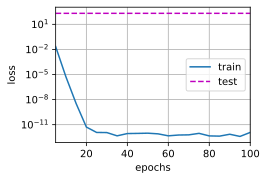

In [11]:
train_concise(0)

## 使用权重衰减

训练误差增大，但是测试误差减小

w的L2范数：  0.3829815089702606


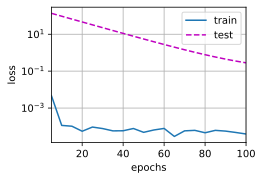

In [12]:
train_concise(3)